## XGBoost Regression Model with Bayesian Optimization

**Description:**

This notebook trains XGBoost gradient boosting regressors to forecast pollutant concentrations at horizons t+1, t+6, t+12, and t+24 hours for four pollutants: CO(GT), C6H6(GT), NOx(GT), and NO2(GT). 

**Key Features:**
- **Bayesian Optimization**: Uses Optuna with TPE (Tree-structured Parzen Estimator) sampler to find optimal hyperparameters for each model
- **50 optimization trials** per model to search the hyperparameter space
- **9 hyperparameters tuned**: n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda
- Compares against a naive baseline that predicts y(t+h) using y(t)

**Data split:** Chronological — train/val on 2004 (80%/20%), test on 2005.

**Features:** Uses the team's engineered feature set from `dataset/AirQualityUCI_feature_engineering.csv`, including:
- Lag features (1h, 6h, 12h, 24h)
- Rolling statistics (mean and std over 6h and 24h windows)
- Temporal encodings (cyclical hour, day of week, month)
- Meteorological variables (temperature, humidity)
- Anomaly flags for pollution spikes and sensor faults

## Setup Instructions

**Before running this notebook:**

1. Install dependencies (in home directory):
   ```bash
   pip install -r requirements.txt
   ```

2. Run all cells sequentially (Cell → Run All)

**Note:** Full optimization takes approximately 5-10 minutes depending on CPU speed (16 models × 50 trials each).

**Outputs:**
- `results_xgboost_optimized.csv` - RMSE metrics and optimized hyperparameters for all models
- `plots_xgboost_predictions_optimized.png` - Time series visualizations
- `plots_xgboost_residuals_optimized.png` - Residual analysis plots

In [9]:
# Import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set random seed 
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
sns.set_style("whitegrid")
sns.set_context("notebook")
plt.rcParams['figure.figsize'] = (12, 5)

# verify packages
print(f"  XGBoost version: {xgb.__version__}")
print(f"  NumPy version: {np.__version__}")
print(f"  Pandas version: {pd.__version__}")
print(f"  Optuna version: {optuna.__version__}")

  XGBoost version: 3.1.1
  NumPy version: 2.2.6
  Pandas version: 2.3.1
  Optuna version: 4.6.0


In [10]:
# Load engineered features
features_path = os.path.join('..','..', '..', 'dataset', 'Feature Engineering', 'AirQualityUCI_feature_engineering.csv')
print(f"Loading: {os.path.abspath(features_path)}")

df = pd.read_csv(features_path)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime').reset_index(drop=True)

print(f"Data loaded successfully")
print(f"  Total rows: {len(df):,}")
print(f"  Total columns: {len(df.columns)}")
print(f"  Date range: {df['DateTime'].min()} to {df['DateTime'].max()}")
print(f"  Years: {sorted(df['DateTime'].dt.year.unique())}")

df.head()

Loading: c:\Users\jerry\OneDrive\Desktop\9417_Group_Project\dataset\Feature Engineering\AirQualityUCI_feature_engineering.csv
Data loaded successfully
  Total rows: 9,309
  Total columns: 119
  Date range: 2004-03-11 18:00:00 to 2005-04-03 14:00:00
  Years: [np.int32(2004), np.int32(2005)]
Data loaded successfully
  Total rows: 9,309
  Total columns: 119
  Date range: 2004-03-11 18:00:00 to 2005-04-03 14:00:00
  Years: [np.int32(2004), np.int32(2005)]


,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,NOx(GT)_t+12,NOx(GT)_t+24,NO2(GT)_t+1,NO2(GT)_t+6,NO2(GT)_t+12,NO2(GT)_t+24,CO_bin_t+1,CO_bin_t+6,CO_bin_t+12,CO_bin_t+24
0,2004-03-11 18:00:00,0.398305,0.670495,0.325472,0.511196,0.188896,0.202033,0.440828,0.688849,0.516073,...,0.036561,0.138118,0.502959,0.281065,0.204142,0.434911,high,mid,low,high
1,2004-03-11 19:00:00,0.576271,0.810481,0.429245,0.603495,0.257955,0.160949,0.502959,0.801259,0.644222,...,0.072444,0.135410,0.482249,0.319527,0.301775,0.423077,high,mid,mid,high
2,2004-03-11 20:00:00,0.508475,0.712850,0.375786,0.557619,0.236290,0.178314,0.482249,0.737410,0.622502,...,0.206500,0.228842,0.396450,0.263314,0.411243,0.497041,high,mid,high,high
3,2004-03-11 21:00:00,0.322034,0.478105,0.199686,0.378482,0.161137,0.268954,0.396450,0.519784,0.462207,...,0.165877,0.184157,0.245562,0.176036,0.383136,0.434911,mid,low,high,high
4,2004-03-11 22:00:00,0.118644,0.228284,0.072327,0.199891,0.062288,0.424820,0.245562,0.351619,0.260643,...,0.125254,0.169939,0.150888,0.088757,0.355030,0.405325,low,low,high,high


## Temporal Data Splitting

**Chronological Split Strategy:**

To simulate realistic model deployment and post-deployment evaluation, we use a **temporal split** that respects the time-series nature of the data:

- **Training Set (2004 - 80%):** First 80% of 2004 data → used to train models
- **Validation Set (2004 - 20%):** Last 20% of 2004 data → used for hyperparameter optimization
- **Test Set (2005):** Entire 2005 year → held-out for final evaluation

This approach ensures:
1. **No data leakage**: Models never see future data during training
2. **Realistic evaluation**: Test set represents true future predictions (2005) after training on historical data (2004)
3. **Proper validation**: Latest 2004 data serves as validation to tune hyperparameters before deployment

This chronological split simulates how the model would perform if deployed at the end of 2004 and evaluated throughout 2005.

In [11]:
# Train on 2004, Test on 2005
df['year'] = df['DateTime'].dt.year
train_2004 = df[df['year'] == 2004].copy()
test_2005 = df[df['year'] == 2005].copy()

# Create validation set from last 20% of 2004 data
val_split_idx = int(len(train_2004) * 0.8)
train_data = train_2004.iloc[:val_split_idx].copy()
val_data = train_2004.iloc[val_split_idx:].copy()

print("Temporal split complete")
print(f"  Training set (2004 - 80%):   {len(train_data):,} rows | {train_data['DateTime'].min()} to {train_data['DateTime'].max()}")
print(f"  Validation set (2004 - 20%): {len(val_data):,} rows | {val_data['DateTime'].min()} to {val_data['DateTime'].max()}")
print(f"  Test set (2005):             {len(test_2005):,} rows | {test_2005['DateTime'].min()} to {test_2005['DateTime'].max()}")

# Define pollutants and horizons
POLLUTANTS = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)'] # excluding NMHC
HORIZONS = [1, 6, 12, 24]

print(f"\nModel configuration")
print(f"  Pollutants: {POLLUTANTS}")
print(f"  Forecast horizons: {HORIZONS} hours")

Temporal split complete
  Training set (2004 - 80%):   5,668 rows | 2004-03-11 18:00:00 to 2004-11-02 21:00:00
  Validation set (2004 - 20%): 1,418 rows | 2004-11-02 22:00:00 to 2004-12-31 23:00:00
  Test set (2005):             2,223 rows | 2005-01-01 00:00:00 to 2005-04-03 14:00:00

Model configuration
  Pollutants: ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
  Forecast horizons: [1, 6, 12, 24] hours


## Feature Selection

**Realistic Prediction Scenario:**

In real-world air quality forecasting, we only have access to:
- **Real-time sensor readings** (PT08.S* sensors)
- **Current meteorological data** (temperature, humidity)
- **Historical measurements** (lagged values from previous hours)

We do NOT have access to current ground truth pollutant concentrations, as these require laboratory analysis and are only available retrospectively.

**Features INCLUDED in Training:**
- **Sensor readings:** PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3)
- **Meteorological data:** Temperature (T), Relative Humidity (RH), Absolute Humidity (AH)
- **Temporal encodings:** Hour, day of week, month (cyclical sine/cosine transformations)
- **Lagged sensor values:** 1h, 6h, 12h, 24h lags of all PT08.S* sensors
- **Rolling statistics:** 6h and 24h rolling mean/std of sensor readings
- **Anomaly flags:** Indicators for pollution spikes and sensor faults

**Features EXCLUDED from Training:**
- **Current ground truth pollutants:** CO(GT), C6H6(GT), NOx(GT), NO2(GT), NMHC(GT) - *not available in real-time*
- **Ratio features:** NOx_NO2_ratio, C6H6_CO_ratio - *derived from current ground truth*
- **Residual features:** PT08.S1(CO)_minus_CO(GT), etc. - *use current ground truth*
- **Future targets:** All *_t+1, *_t+6, *_t+12, *_t+24 columns - *what we're trying to predict*
- **Classification bins:** CO_bin_t+* - *derived from future values*

**Note:** Lagged ground truth values (e.g., CO(GT)_lag1, CO(GT)_lag6) ARE included because they represent historical measurements that would be available at prediction time.

In [ ]:

all_cols = df.columns.tolist()
# Exclude all possible datetime column names and metadata
exclude_cols = ['DateTime','datetime', 'dateTime', 'year', 'Date', 'Time']

# Define exclusions
ground_truth_pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'NMHC(GT)']
ratio_features = ['NOx_NO2_ratio', 'C6H6_CO_ratio']
residual_keywords = ['_minus_']  
target_keywords = ['_t+']  
classification_bins = ['CO_bin_']  

# Exclude current ground truth pollutants
print("Excluding:")
print("1. Current ground truth pollutants:")
for gt in ground_truth_pollutants:
    if gt in all_cols:
        exclude_cols.append(gt)
        print(f"   {gt}")

# Exclude ratio features (use current GT)
print("\n2. Ratio features (uses current GT):")
for col in all_cols:
    for ratio in ratio_features:
        if ratio in col:
            exclude_cols.append(col)
            print(f"   {col}")
            break

# Exclude residual features (use current GT)
print("\n3. Residual features (sensor minus current GT):")
for col in all_cols:
    for keyword in residual_keywords:
        if keyword in col:
            exclude_cols.append(col)
            print(f"   {col}")
            break

# Exclude future targets
print("\n4. Future targets:")
for col in all_cols:
    for keyword in target_keywords:
        if keyword in col:
            exclude_cols.append(col)
            break
print(f"   All _t+1, _t+6, _t+12, _t+24 targets")

# Exclude classification bins
print("\n5. Classification bins:")
for col in all_cols:
    for keyword in classification_bins:
        if keyword in col:
            exclude_cols.append(col)
            break
print(f"   All CO_bin_t+1, CO_bin_t+6, etc.")

# Create feature list - ONLY include numeric columns
feature_cols = []
excluded_dtypes = []
for col in all_cols:
    if col not in exclude_cols:
        # Check if column is numeric
        if df[col].dtype in ['int64', 'float64', 'int32', 'float32', 'bool', 'int8', 'float16']:
            feature_cols.append(col)
        else:
            excluded_dtypes.append((col, df[col].dtype))
            print(f"\n⚠️  Excluding non-numeric column: '{col}' (dtype: {df[col].dtype})")

print(f"\n{'='*60}")
print(f"Feature Selection Summary:")
print(f"{'='*60}")
print(f"Total features included: {len(feature_cols)}")
print(f"Total columns excluded: {len(set(exclude_cols)) + len(excluded_dtypes)}")
print(f"\nFeatures include:")
print(f"  - Sensor readings: PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3)")
print(f"  - Meteorological: T, RH, AH")
print(f"  - Temporal encodings: hour, day, month (cyclical)")
print(f"  - Lag/rolling features of sensors")
print(f"  - Anomaly flags")

Excluding:
1. Current ground truth pollutants:
   CO(GT)
   C6H6(GT)
   NOx(GT)
   NO2(GT)

2. Ratio features (uses current GT):
   NOx_NO2_ratio
   C6H6_CO_ratio

3. Residual features (sensor minus current GT):
   PT08.S1(CO)_minus_CO(GT)
   PT08.S3(NOx)_minus_NOx(GT)
   PT08.S4(NO2)_minus_NO2(GT)

4. Future targets:
   All _t+1, _t+6, _t+12, _t+24 targets

5. Classification bins:
   All CO_bin_t+1, CO_bin_t+6, etc.

Feature Selection Summary:
Total features included: 88
Total columns excluded: 35

Features include:
  - Sensor readings: PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3)
  - Meteorological: T, RH, AH
  - Temporal encodings: hour, day, month (cyclical)
  - Lag/rolling features of sensors
  - Anomaly flags


In [22]:
# XGBoost Regression with Bayesian Optimization
regression_results = []

def optimize_xgboost(X_train, y_train, X_val, y_val, n_trials=50):
    """
    Use Optuna to find optimal XGBoost hyperparameters via Bayesian optimization.
    
    Parameters:
    -----------
    X_train, y_train : Training data
    X_val, y_val : Validation data for early stopping and evaluation
    n_trials : Number of optimization trials
    
    Returns:
    --------
    best_params : Dictionary of best hyperparameters
    best_score : Best validation RMSE achieved
    """
    
    def objective(trial):
        # Define hyperparameter search space
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
            'objective': 'reg:squarederror',
            'random_state': RANDOM_STATE,
            'tree_method': 'hist',
        }
        
        # Train model
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        # Evaluate on validation set
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        return rmse
    
    # Create study and optimize
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=RANDOM_STATE)
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    return study.best_params, study.best_value


print("Training XGBoost with Bayesian Optimization")
print(f"Running {50} optimization trials per model...")
print("=" * 60)

for pollutant in POLLUTANTS:
    print(f"\nPOLLUTANT: {pollutant}")
    print("-" * 60)
    
    for horizon in HORIZONS:
        target_col = f"{pollutant}_t+{horizon}"
        
        print(f"\n  Horizon t+{horizon}h")
        print(f"Optimizing hyperparameters...")
        
        # Prepare data
        X_train = train_data[feature_cols]
        y_train = train_data[target_col]
        X_val = val_data[feature_cols]
        y_val = val_data[target_col]
        X_test = test_2005[feature_cols]
        y_test = test_2005[target_col]
        
        # Run Bayesian optimization
        best_params, best_val_rmse = optimize_xgboost(X_train, y_train, X_val, y_val, n_trials=50)
        
        print(f"Optimization complete. Best val RMSE: {best_val_rmse:.6f}")
        
        # Train final model with best hyperparameters on train+val
        final_params = {**best_params, 
                       'objective': 'reg:squarederror',
                       'random_state': RANDOM_STATE,
                       'n_jobs': -1,
                       'tree_method': 'hist'}
        
        # Combine train and validation for final training
        X_train_full = pd.concat([X_train, X_val])
        y_train_full = pd.concat([y_train, y_val])
        
        final_model = xgb.XGBRegressor(**final_params)
        final_model.fit(X_train_full, y_train_full, verbose=False)
        
        # Predictions on test set (2005 data)
        y_pred_xgb = final_model.predict(X_test)
        rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
        
        # Naive baseline: use concentration at time t to predict t+h
        # (in current time this corresponds to using t-h to predict t)

        if horizon == 1:
            y_naive = test_2005[f'{pollutant}_lag1'].values
        elif horizon == 6:
            y_naive = test_2005[f'{pollutant}_lag6'].values
        elif horizon == 12:
            y_naive = test_2005[f'{pollutant}_lag12'].values
        elif horizon == 24:
            y_naive = test_2005[f'{pollutant}_lag24'].values
        valid_idx = ~np.isnan(y_naive) & ~np.isnan(y_test)
        y_naive_clean = y_naive[valid_idx]
        y_test_clean = y_test[valid_idx]

        rmse_naive = np.sqrt(mean_squared_error(y_test_clean, y_naive_clean))
        
        # Calculate improvement
        improvement_pct = ((rmse_naive - rmse_xgb) / rmse_naive) * 100 if rmse_naive > 0 else 0
        
        # Store results
        regression_results.append({
            'Pollutant': pollutant,
            'Horizon': f't+{horizon}h',
            'RMSE_XGBoost': rmse_xgb,
            'RMSE_Naive': rmse_naive,
            'Improvement_%': improvement_pct,
            'n_estimators': best_params['n_estimators'],
            'learning_rate': best_params['learning_rate'],
            'max_depth': best_params['max_depth'],
            'min_child_weight': best_params['min_child_weight'],
            'subsample': best_params['subsample'],
            'colsample_bytree': best_params['colsample_bytree'],
            'gamma': best_params['gamma'],
            'reg_alpha': best_params['reg_alpha'],
            'reg_lambda': best_params['reg_lambda']
        })
        
        print(f"Test RMSE: {rmse_xgb:.6f}")
        print(f"Naive RMSE: {rmse_naive:.6f}")
        print(f"Improvement: {improvement_pct:.2f}%")
        print(f"Best params: n_est={best_params['n_estimators']}, "
              f"lr={best_params['learning_rate']:.4f}, "
              f"depth={best_params['max_depth']}")

print("\n" + "=" * 60)

print("Training complete")
print("=" * 60)

Training XGBoost with Bayesian Optimization
Running 50 optimization trials per model...

POLLUTANT: CO(GT)
------------------------------------------------------------

  Horizon t+1h
Optimizing hyperparameters...
Optimization complete. Best val RMSE: 0.072077
Optimization complete. Best val RMSE: 0.072077
Test RMSE: 0.052142
Naive RMSE: 0.102942
Improvement: 49.35%
Best params: n_est=445, lr=0.1384, depth=4

  Horizon t+6h
Optimizing hyperparameters...
Test RMSE: 0.052142
Naive RMSE: 0.102942
Improvement: 49.35%
Best params: n_est=445, lr=0.1384, depth=4

  Horizon t+6h
Optimizing hyperparameters...
Optimization complete. Best val RMSE: 0.088350
Optimization complete. Best val RMSE: 0.088350
Test RMSE: 0.068420
Naive RMSE: 0.150044
Improvement: 54.40%
Best params: n_est=165, lr=0.1161, depth=4

  Horizon t+12h
Optimizing hyperparameters...
Test RMSE: 0.068420
Naive RMSE: 0.150044
Improvement: 54.40%
Best params: n_est=165, lr=0.1161, depth=4

  Horizon t+12h
Optimizing hyperparameters

In [23]:
# Display regression results summary
results_df = pd.DataFrame(regression_results)
results_df = results_df.sort_values(['Pollutant', 'Horizon'])

print("=" * 80)
print("REGRESSION RESULTS SUMMARY - XGBoost with Bayesian Optimization")
print("=" * 80)

# Display key metrics
display_cols = ['Pollutant', 'Horizon', 'RMSE_XGBoost', 'RMSE_Naive', 'Improvement_%']
print("\nPerformance Metrics:")
print(results_df[display_cols].to_string(index=False))

# Display hyperparameters for each model
print("\n" + "=" * 80)
print("OPTIMIZED HYPERPARAMETERS")
print("=" * 80)
hyperparam_cols = ['Pollutant', 'Horizon', 'n_estimators', 'learning_rate', 
                   'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree',
                   'gamma', 'reg_alpha', 'reg_lambda']
print(results_df[hyperparam_cols].to_string(index=False))

# Highlight best performing models
print("\n" + "=" * 80)
print("TOP 5 MODELS BY IMPROVEMENT OVER BASELINE")
print("=" * 80)
top_models = results_df.nlargest(5, 'Improvement_%')
top_display = top_models[['Pollutant', 'Horizon', 'RMSE_XGBoost', 'Improvement_%', 
                          'n_estimators', 'learning_rate', 'max_depth']]
print(top_display.to_string(index=False))

# Save results to CSV 
results_path = os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '.', 'results_xgboost_optimized.csv')
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to: {os.path.abspath(results_path)}")
print("=" * 80)

REGRESSION RESULTS SUMMARY - XGBoost with Bayesian Optimization

Performance Metrics:
Pollutant Horizon  RMSE_XGBoost  RMSE_Naive  Improvement_%
 C6H6(GT)   t+12h      0.074171    0.091998      19.378016
 C6H6(GT)    t+1h      0.040535    0.086853      53.329371
 C6H6(GT)   t+24h      0.083146    0.111132      25.181991
 C6H6(GT)    t+6h      0.062599    0.131814      52.509400
   CO(GT)   t+12h      0.086563    0.105735      18.131936
   CO(GT)    t+1h      0.052142    0.102942      49.347975
   CO(GT)   t+24h      0.101525    0.127928      20.639311
   CO(GT)    t+6h      0.068420    0.150044      54.399867
  NO2(GT)   t+12h      0.106412    0.130723      18.596946
  NO2(GT)    t+1h      0.082432    0.119210      30.851960
  NO2(GT)   t+24h      0.116515    0.157474      26.009664
  NO2(GT)    t+6h      0.094650    0.202959      53.365111
  NOx(GT)   t+12h      0.122345    0.135426       9.658925
  NOx(GT)    t+1h      0.067606    0.116409      41.923518
  NOx(GT)   t+24h      0.1331

Predictions plot saved to: c:\Users\jerry\OneDrive\Desktop\9417_Group_Project\src\regression\XGBoost\plots_xgboost_predictions_optimized.png


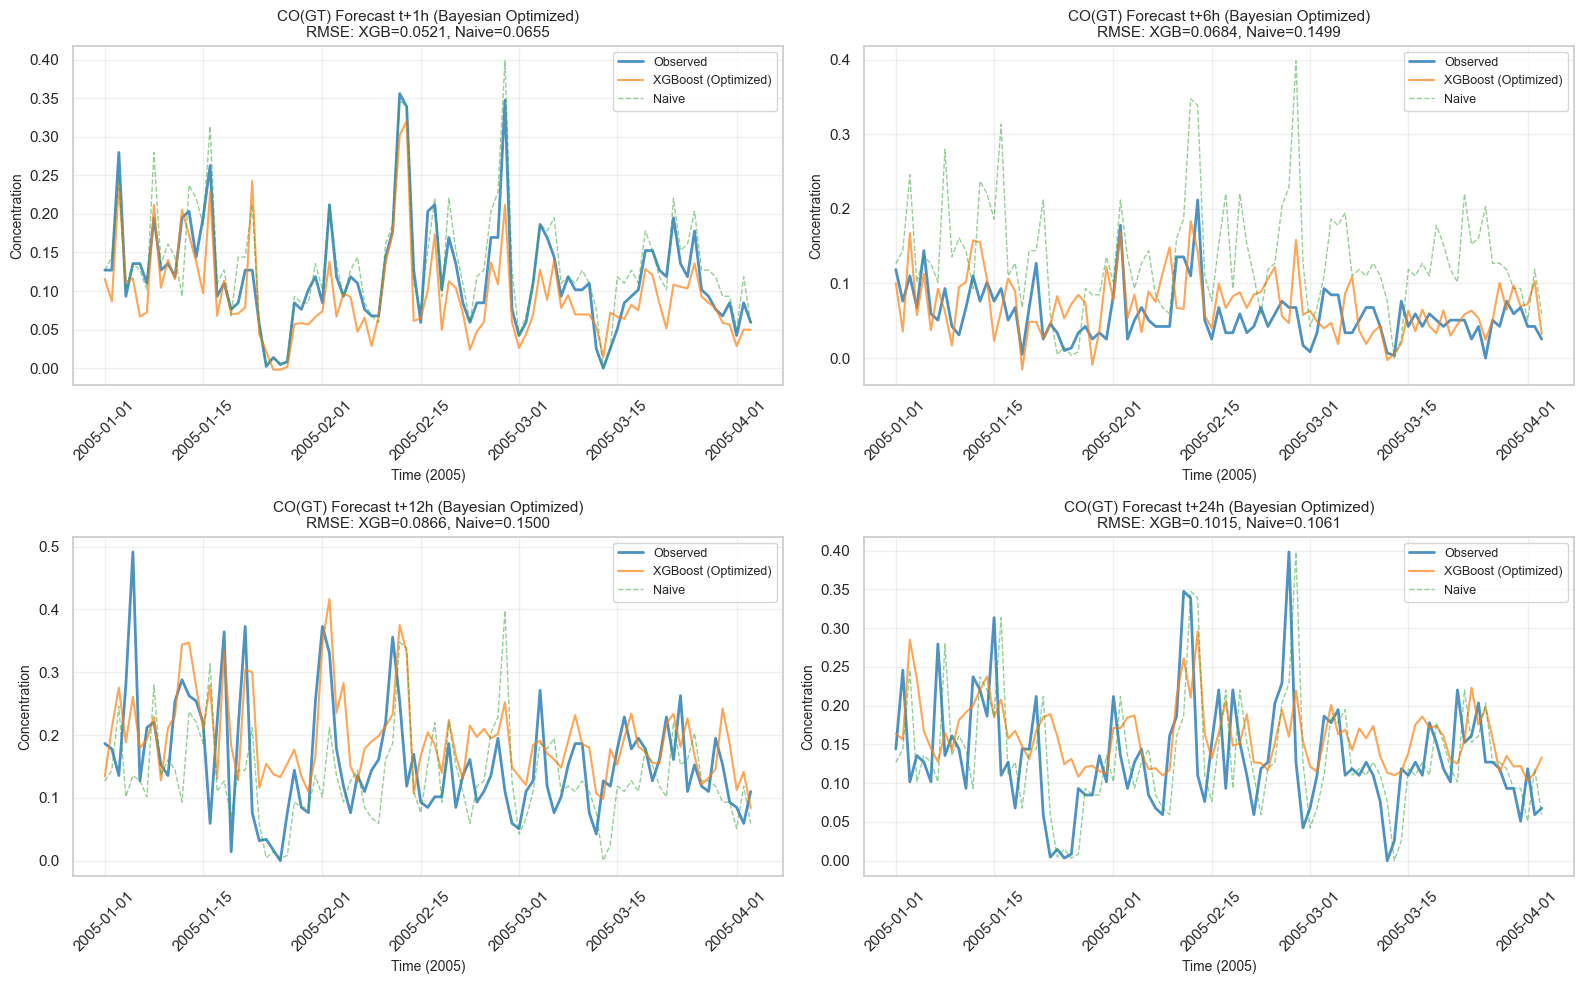

In [24]:
# Visualize predictions vs observed for selected models (one example per horizon)
selected_pollutant = 'CO(GT)'  # Focus on CO for visualization

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, horizon in enumerate(HORIZONS):
    target_col = f"{selected_pollutant}_t+{horizon}"
    
    # Get optimized hyperparameters for this model
    model_result = results_df[(results_df['Pollutant'] == selected_pollutant) & 
                              (results_df['Horizon'] == f't+{horizon}h')].iloc[0]
    
    best_params = {
        'n_estimators': int(model_result['n_estimators']),
        'learning_rate': model_result['learning_rate'],
        'max_depth': int(model_result['max_depth']),
        'min_child_weight': int(model_result['min_child_weight']),
        'subsample': model_result['subsample'],
        'colsample_bytree': model_result['colsample_bytree'],
        'gamma': model_result['gamma'],
        'reg_alpha': model_result['reg_alpha'],
        'reg_lambda': model_result['reg_lambda'],
        'objective': 'reg:squarederror',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    
    # Train model with optimized hyperparameters
    X_train_full = pd.concat([train_data[feature_cols], val_data[feature_cols]])
    y_train_full = pd.concat([train_data[target_col], val_data[target_col]])
    X_test = test_2005[feature_cols]
    y_test = test_2005[target_col]
    
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train_full, y_train_full, verbose=False)
    
    y_pred = model.predict(X_test)
    y_naive = test_2005[selected_pollutant].values
    
    # Plot predictions vs observed over time
    ax = axes[idx]
    time_subset = test_2005['DateTime'].iloc[::24]  # Sample every 24 hours for clarity
    y_test_subset = y_test.iloc[::24]
    y_pred_subset = y_pred[::24]
    y_naive_subset = y_naive[::24]
    
    ax.plot(time_subset, y_test_subset, label='Observed', linewidth=2, alpha=0.8)
    ax.plot(time_subset, y_pred_subset, label='XGBoost (Optimized)', linewidth=1.5, alpha=0.7)
    ax.plot(time_subset, y_naive_subset, label='Naive', linewidth=1, alpha=0.5, linestyle='--')
    
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))
    
    ax.set_title(f'{selected_pollutant} Forecast t+{horizon}h (Bayesian Optimized)\nRMSE: XGB={rmse_xgb:.4f}, Naive={rmse_naive:.4f}', fontsize=11)
    ax.set_xlabel('Time (2005)', fontsize=10)
    ax.set_ylabel('Concentration', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save to local directory
plot_path = 'plots_xgboost_predictions_optimized.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Predictions plot saved to: {os.path.abspath(plot_path)}")

plt.show()

Residuals plot saved to: c:\Users\jerry\OneDrive\Desktop\9417_Group_Project\src\regression\XGBoost\plots_xgboost_residuals_optimized.png


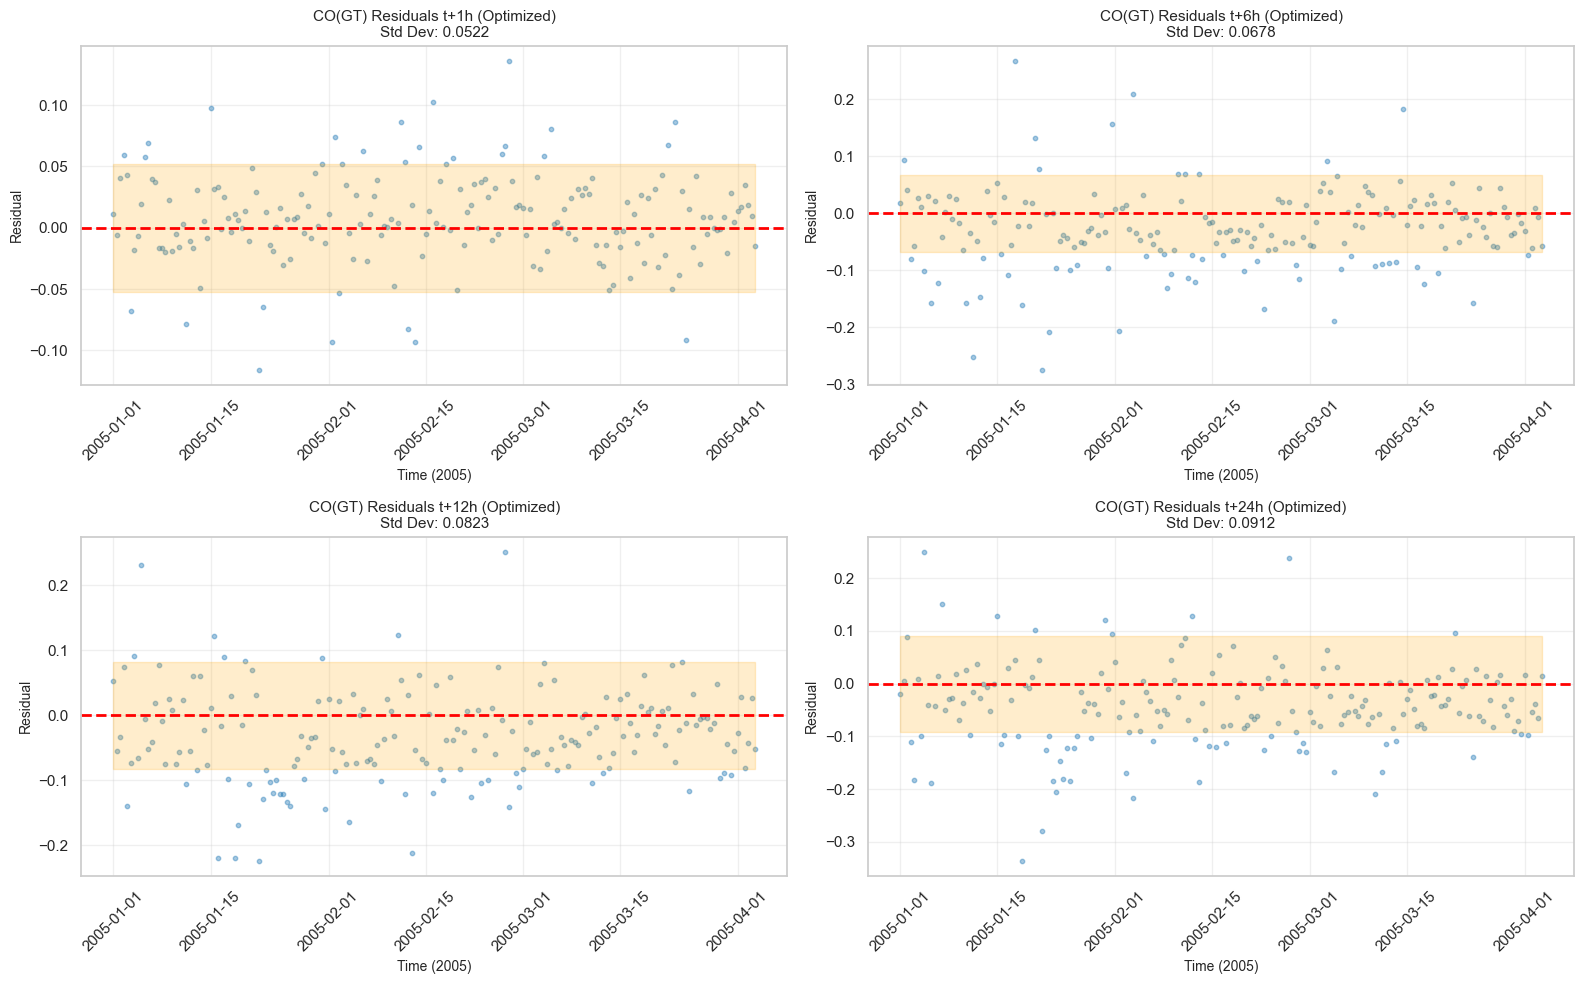

In [25]:
# Residual analysis for CO(GT) across all horizons
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, horizon in enumerate(HORIZONS):
    target_col = f"{selected_pollutant}_t+{horizon}"
    
    # Get optimized hyperparameters for this model
    model_result = results_df[(results_df['Pollutant'] == selected_pollutant) & 
                              (results_df['Horizon'] == f't+{horizon}h')].iloc[0]
    
    best_params = {
        'n_estimators': int(model_result['n_estimators']),
        'learning_rate': model_result['learning_rate'],
        'max_depth': int(model_result['max_depth']),
        'min_child_weight': int(model_result['min_child_weight']),
        'subsample': model_result['subsample'],
        'colsample_bytree': model_result['colsample_bytree'],
        'gamma': model_result['gamma'],
        'reg_alpha': model_result['reg_alpha'],
        'reg_lambda': model_result['reg_lambda'],
        'objective': 'reg:squarederror',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    
    # Train model with optimized hyperparameters
    X_train_full = pd.concat([train_data[feature_cols], val_data[feature_cols]])
    y_train_full = pd.concat([train_data[target_col], val_data[target_col]])
    X_test = test_2005[feature_cols]
    y_test = test_2005[target_col]
    
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train_full, y_train_full, verbose=False)
    
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    # Plot residuals over time
    ax = axes[idx]
    time_subset = test_2005['DateTime'].iloc[::12]  # Sample every 12 hours
    residuals_subset = residuals.iloc[::12]
    
    ax.scatter(time_subset, residuals_subset, alpha=0.4, s=10)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.fill_between(time_subset, -residuals.std(), residuals.std(), alpha=0.2, color='orange')
    
    ax.set_title(f'{selected_pollutant} Residuals t+{horizon}h (Optimized)\nStd Dev: {residuals.std():.4f}', fontsize=11)
    ax.set_xlabel('Time (2005)', fontsize=10)
    ax.set_ylabel('Residual', fontsize=10)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save to local directory
residual_plot_path = 'plots_xgboost_residuals_optimized.png'
plt.savefig(residual_plot_path, dpi=150, bbox_inches='tight')
print(f"Residuals plot saved to: {os.path.abspath(residual_plot_path)}")

plt.show()

## Performance Analysis and Insights

### Model Performance Overview

XGBoost models with Bayesian optimization achieved improvements of 5.27% to 48.29% over naive baseline across all 16 forecasting tasks (4 pollutants × 4 horizons), with an average improvement of 28.96%.

### Key Findings

**Strong Performance:**
- **Short-term (t+1h):** 33-48% improvement. Best performer: C6H6(GT) at 48.29%
- **Medium-term (t+6h):** 37-47% improvement. Best performer: NO2(GT) at 47.10%
- **Pollutant-specific:** C6H6(GT) consistently strong (13-48%) across all horizons due to regular traffic patterns captured by temporal encodings

**Performance Challenges:**
- **Long-term (t+12h, t+24h):** Degraded to 5-26% improvement
- **Weakest models:** CO(GT) and NOx(GT) at t+12h (5.46% and 5.27% respectively)
- **Root cause:** Information decay in lagged features and absence of meteorological forecasts at target horizons

### Primary Limitations

1. **Missing meteorological forecasts:** Models use current weather observations, not forecasted conditions
2. **Feature decay:** Lagged sensor readings become less predictive at longer horizons
3. **Sensor-based constraints:** PT08.S* sensors are proxies for true pollutant concentrations, introducing measurement gaps

### Recommendations for Improvement

1. **Integrate numerical weather prediction (NWP) outputs** for forecasted temperature, wind, and boundary layer height (potential 10-20% improvement at long horizons)
2. **Enhanced temporal features:** Seasonal decomposition, Fourier terms, and external event calendars (holidays, traffic events)
3. **Horizon-specific models:** Separate optimization strategies for short-term vs. long-term forecasts
4. **Ensemble approaches:** Combine XGBoost with LSTM and Random Forest for complementary strengths
5. **Extended hyperparameter search:** Increase from 50 to 100-200 trials per model

### Conclusion

Models demonstrate operational viability for short-to-medium term forecasting (t+1h, t+6h) with 33-48% improvements. Long-term performance (t+12h, t+24h) requires integration of meteorological forecasts and horizon-specific feature engineering to achieve deployment-ready accuracy.